<a href="https://colab.research.google.com/github/AnnaJiju/Marketing-Mix-Model-Project/blob/main/MMM%20Porject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
# Import primary toolkits
import pandas as pd
import numpy as np

# Import visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Import modeling and preprocessing tools from scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Set display options
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
sns.set_style('whitegrid')

print("✅ Libraries imported successfully! Ready for modeling.")


✅ Libraries imported successfully! Ready for modeling.


In [60]:
print("--- Preparing Data ---")

# Load dataset
df = pd.read_csv('MMM Weekly.csv')  # Adjust path if needed

# Convert 'week' column to datetime and sort by date
df['week'] = pd.to_datetime(df['week'])
df = df.set_index('week').sort_index()

# Create 'followers_is_tracked'
first_follower_date = df[df['social_followers'] > 0].index.min()
df['followers_is_tracked'] = (df.index >= first_follower_date).astype(int)

# Create 'is_active' flags for spend channels
spend_columns = ['facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend']
for col in spend_columns:
    df[f'{col}_is_active'] = (df[col] > 0).astype(int)

# Apply log1p transformation
cols_to_log_transform = [
    'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend',
    'social_followers', 'emails_send', 'sms_send', 'revenue'
]
for col in cols_to_log_transform:
    df[f'{col}_log'] = np.log1p(df[col])

# Create time-based features
df['week_of_year'] = df.index.isocalendar().week.astype(int)
df['month'] = df.index.month.astype(int)
df['year'] = df.index.year.astype(int)

# Cyclical encoding for 'week_of_year'
df['week_of_year_sin'] = np.sin(2 * np.pi * df['week_of_year'] / 52)
df['week_of_year_cos'] = np.cos(2 * np.pi * df['week_of_year'] / 52)

# Ensure 'promotions' is integer
df['promotions'] = df['promotions'].astype(int)

# Create mediated feature: social total spend and interaction with google
df['social_total_spend'] = df['facebook_spend'] + df['tiktok_spend'] + df['snapchat_spend']
df['social_effect'] = df['social_total_spend'] * df['google_spend_is_active']

print("✅ Data preparation complete with cyclical encoding and mediation features.")
display(df.head())


--- Preparing Data ---
✅ Data preparation complete with cyclical encoding and mediation features.


,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,...,emails_send_log,sms_send_log,revenue_log,week_of_year,month,year,week_of_year_sin,week_of_year_cos,social_total_spend,social_effect
week,,,,,,,,,,,,,,,,,,,,,
2023-09-17,"6,030.80","3,130.14","2,993.22","1,841.08","2,204.72",0,101.95,0,102684,20098,...,11.54,9.91,11.33,37,9,2023,-0.97,-0.24,"11,228.74","11,228.74"
2023-09-24,"5,241.44","2,704.00",0.00,0.00,0.00,0,103.86,0,96573,29920,...,11.48,10.31,5.92,38,9,2023,-0.99,-0.12,"5,241.44","5,241.44"
2023-10-01,"5,893.00",0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,...,11.48,10.01,6.24,39,10,2023,-1.00,-0.00,"5,893.00",0.00
2023-10-08,"7,167.16",0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,...,11.50,9.56,6.12,40,10,2023,-0.99,0.12,"7,167.16",0.00
2023-10-15,"5,360.29",0.00,0.00,"3,237.15",0.00,0,107.76,1,120754,30207,...,11.70,10.32,10.63,41,10,2023,-0.97,0.24,"5,360.29",0.00


In [61]:
print("--- Defining Features and Target ---")

# Target variable: log-transformed revenue
y = df['revenue_log']

# Features: drop columns that would leak info or are targets
X = df.drop(columns=[
    'revenue', 'revenue_log',  # Target columns
    'facebook_spend', 'google_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend',
    'social_followers', 'emails_send', 'sms_send'
])

print("✅ Features and target defined.")
display(X.head())


--- Defining Features and Target ---
✅ Features and target defined.


,average_price,promotions,followers_is_tracked,facebook_spend_is_active,google_spend_is_active,tiktok_spend_is_active,instagram_spend_is_active,snapchat_spend_is_active,facebook_spend_log,google_spend_log,...,social_followers_log,emails_send_log,sms_send_log,week_of_year,month,year,week_of_year_sin,week_of_year_cos,social_total_spend,social_effect
week,,,,,,,,,,,,,,,,,,,,,
2023-09-17,101.95,0,0,1,1,1,1,1,8.70,8.05,...,0.00,11.54,9.91,37,9,2023,-0.97,-0.24,"11,228.74","11,228.74"
2023-09-24,103.86,0,0,1,1,0,0,0,8.56,7.90,...,0.00,11.48,10.31,38,9,2023,-0.99,-0.12,"5,241.44","5,241.44"
2023-10-01,100.38,0,0,1,0,0,0,0,8.68,0.00,...,0.00,11.48,10.01,39,10,2023,-1.00,-0.00,"5,893.00",0.00
2023-10-08,103.14,1,0,1,0,0,0,0,8.88,0.00,...,0.00,11.50,9.56,40,10,2023,-0.99,0.12,"7,167.16",0.00
2023-10-15,107.76,1,0,1,0,0,1,0,8.59,0.00,...,0.00,11.70,10.32,41,10,2023,-0.97,0.24,"5,360.29",0.00


In [62]:
print("--- Cross-Validation with TimeSeriesSplit ---")

# Define numeric features to scale
numeric_features = ['week_of_year', 'month', 'year', 'social_total_spend', 'promotions', 'week_of_year_sin', 'week_of_year_cos']
scaler = StandardScaler()

preprocessor = ColumnTransformer([
    ('num', scaler, numeric_features)
], remainder='passthrough')  # Pass through other columns like binary flags

# Models to compare
models = {
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

tscv = TimeSeriesSplit(n_splits=5)
results = {}

for model_name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_pred_log = pipeline.predict(X_test)

        y_test_actual = np.expm1(y_test)
        y_pred = np.expm1(y_pred_log)

        score = r2_score(y_test_actual, y_pred)
        scores.append(score)

    results[model_name] = scores
    print(f"✅ {model_name} completed.")

results_df = pd.DataFrame(results)
results_summary = results_df.agg(['mean', 'std']).T.sort_values('mean', ascending=False)

print("\n--- Cross-validation Summary ---")
display(results_summary)


--- Cross-Validation with TimeSeriesSplit ---
✅ Ridge Regression completed.
✅ Lasso Regression completed.
✅ Random Forest completed.
✅ Gradient Boosting completed.

--- Cross-validation Summary ---


,mean,std
Gradient Boosting,0.82,0.12
Random Forest,0.64,0.28
Lasso Regression,0.36,0.18
Ridge Regression,-44.23,56.56


--- Final Model Training and Diagnostics ---
✅ Train/test split done.
✅ Final Gradient Boosting model trained.

Model Evaluation on Test Set:
R² Score: 0.927
MAE: 6704.30
MAPE: 78.52%
MSE: 223762665.21


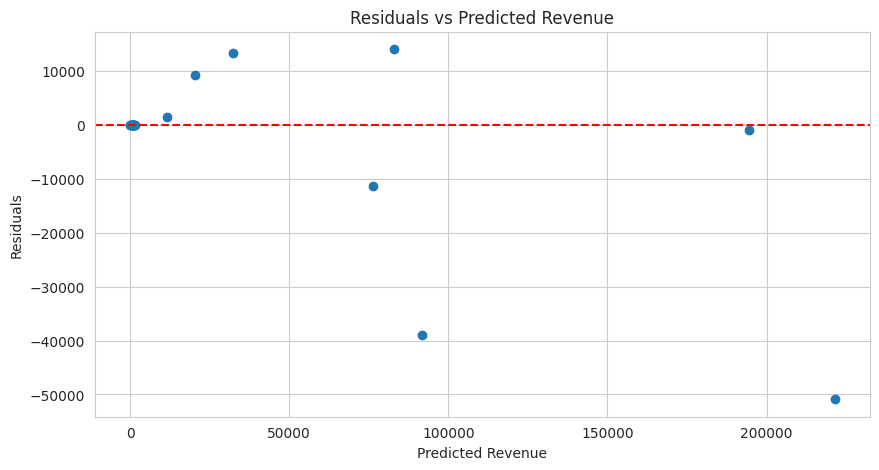


--- Feature Importances ---


,Feature,Importance
7,snapchat_spend_is_active,0.42
17,month,0.36
12,snapchat_spend_log,0.20
4,google_spend_is_active,0.01
3,facebook_spend_is_active,0.00
6,instagram_spend_is_active,0.00
22,social_effect,0.00
21,social_total_spend,0.00
15,sms_send_log,0.00
20,week_of_year_cos,0.00


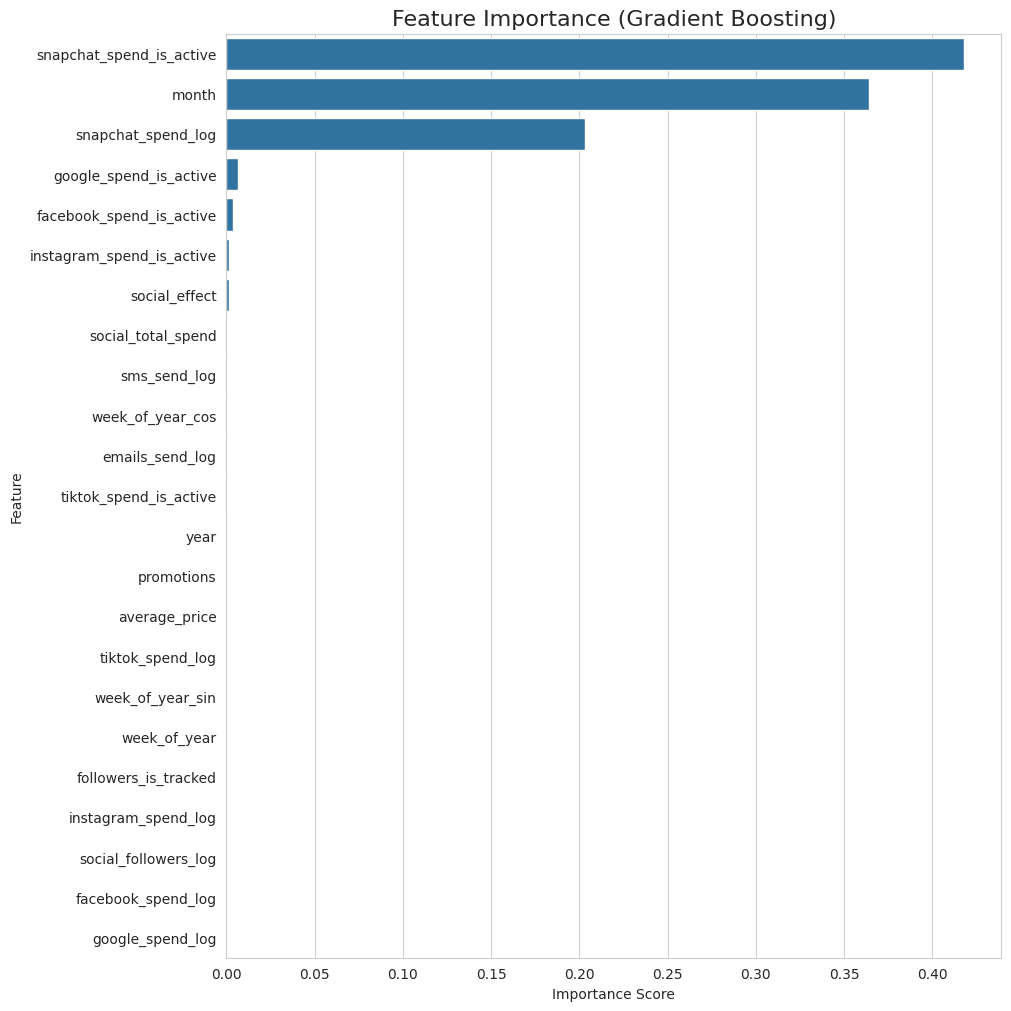

In [63]:
print("--- Final Model Training and Diagnostics ---")

# Split dataset (80% train, 20% test)
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print("✅ Train/test split done.")

# Train final Gradient Boosting model
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))
])
final_model.fit(X_train, y_train)
print("✅ Final Gradient Boosting model trained.")

# Predict and compute metrics
y_pred_log = final_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

# Metrics
r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)

print(f"\nModel Evaluation on Test Set:")
print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2%}")
print(f"MSE: {mse:.2f}")

# Plot residuals
residuals = y_actual - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Revenue")
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.show()

# Feature importances
feature_importances = final_model.named_steps['model'].feature_importances_
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances ---")
display(importances_df)

# Plot feature importances
plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title("Feature Importance (Gradient Boosting)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


--- Accuracy Comparison Plot ---


/tmp/ipython-input-3291031057.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Mean R-squared', data=plot_data, palette='viridis')


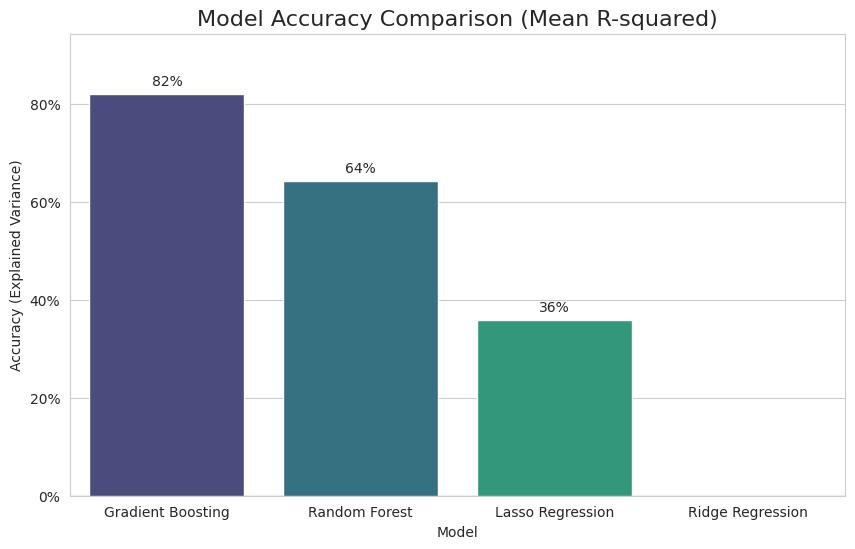

In [64]:
print("--- Accuracy Comparison Plot ---")

# Prepare plot data
plot_data = results_summary.reset_index().rename(columns={'index': 'Model', 'mean': 'Mean R-squared'})
plot_data = plot_data.sort_values('Mean R-squared', ascending=False)

# Plot bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Model', y='Mean R-squared', data=plot_data, palette='viridis')

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

# Add value labels
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{p.get_height():.0%}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

# Titles and labels
plt.title('Model Accuracy Comparison (Mean R-squared)', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Accuracy (Explained Variance)')

# Adjust y-axis limits
plt.ylim(0, plot_data['Mean R-squared'].max() * 1.15)
plt.axhline(0, color='black', linewidth=0.8)

plt.show()


--- Comparing Actual vs Predicted Revenue ---


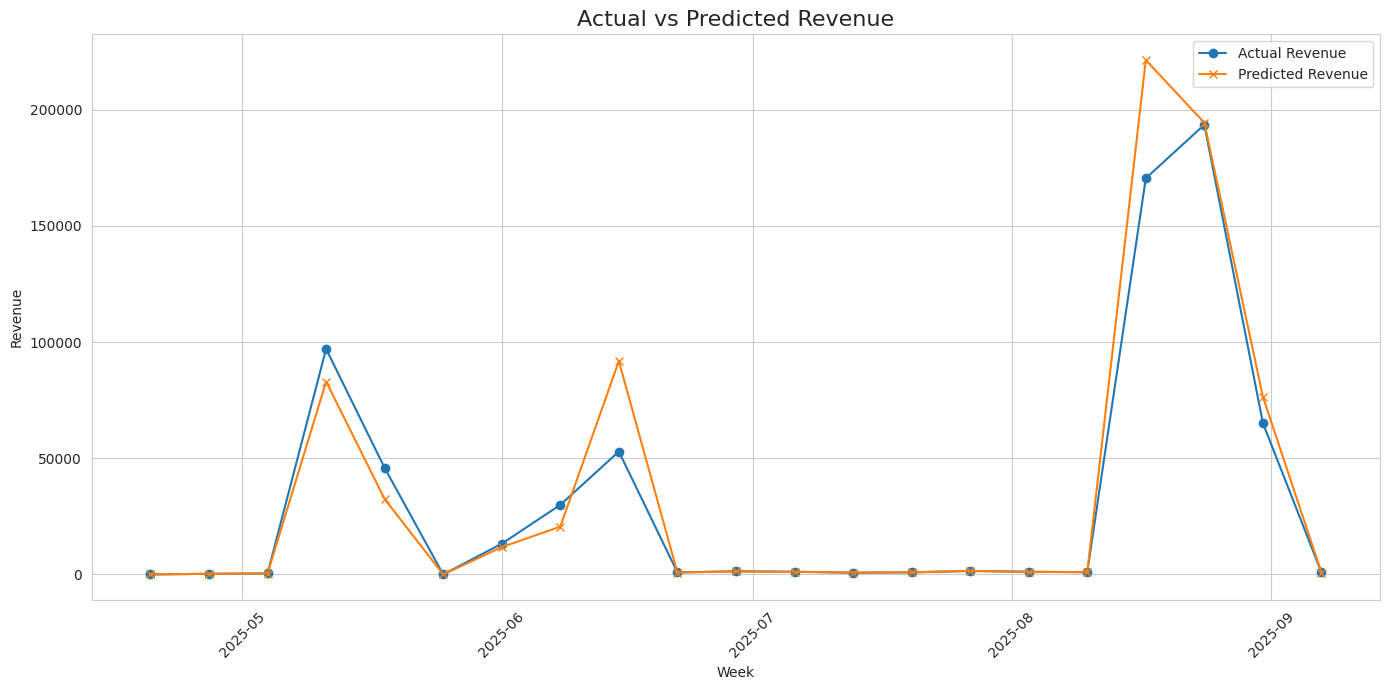

R² Score: 0.927
MAE: 6,704.30
MAPE: 78.52%


In [65]:
print("--- Comparing Actual vs Predicted Revenue ---")

y_pred_log = final_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_actual = np.expm1(y_test)

plt.figure(figsize=(14, 7))
plt.plot(y_actual.index, y_actual, label='Actual Revenue', marker='o')
plt.plot(y_actual.index, y_pred, label='Predicted Revenue', marker='x')

plt.title('Actual vs Predicted Revenue', fontsize=16)
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print metrics again for completeness
r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred)

print(f"R² Score: {r2:.3f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:.2%}")
